In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import random
import torch
import string
import re
import nltk
from nltk.corpus import stopwords
from transformers import DistilBertTokenizer, DistilBertModel


from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
import string
import torchmetrics

from transformers import pipeline
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from google.colab import drive
drive.mount('/content/drive')


<ipython-input-36-2c2db57bbe0a>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data = pd.read_csv('/content/drive/MyDrive/datasets/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/datasets/test.csv')
train_df = train_data

In [ ]:
#Seed evertyhing so that we produce same result again

DEFAULT_SEED: int = 1234

random.seed(DEFAULT_SEED)
np.random.seed(DEFAULT_SEED)
torch.manual_seed(DEFAULT_SEED)
torch.cuda.manual_seed(DEFAULT_SEED)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_df.nunique()

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

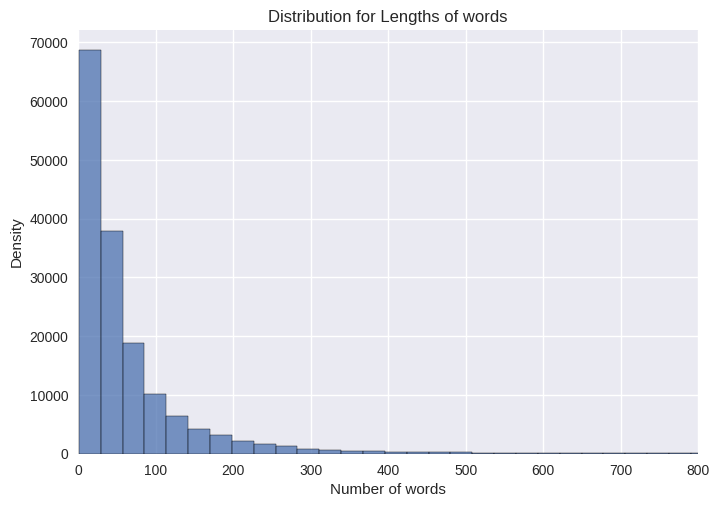

In [ ]:
comment_length =train_df['comment_text'].str.split().apply(len)
sns.histplot(comment_length,bins=50,)
plt.title("Distribution for Lengths of words")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.xlim(0, 800)
plt.show()

In [ ]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
#Creating seperate column in dataframe to identify clean comments. -We use axis=1 to count row-wise and axis=0 to count column wise
rowSums = train_df.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of comments = ",len(train_df))
print("Number of clean comments = ",clean_comments_count)
print("Number of comments with labels =",(len(train_df)-clean_comments_count))


Total number of comments =  159571
Number of clean comments =  143346
Number of comments with labels = 16225


In [ ]:
print(f"{round(clean_comments_count /len(train_df),3)} % percentage of rows contains only zeros in training data")

0.898 % percentage of rows contains only zeros in training data


In [ ]:
categories = list(train_df.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
counts = []
for category in categories:
    counts.append((category, train_df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


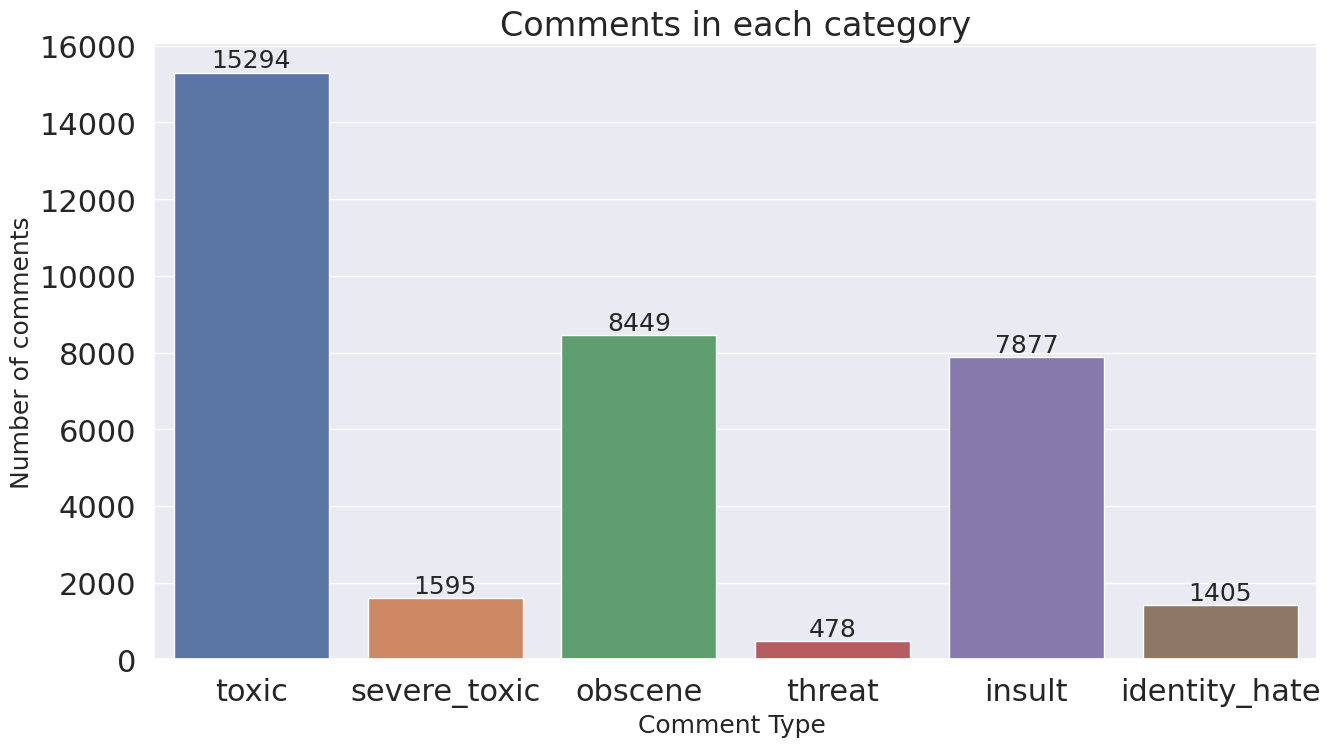

In [ ]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(x=categories, y=train_df.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = train_df.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

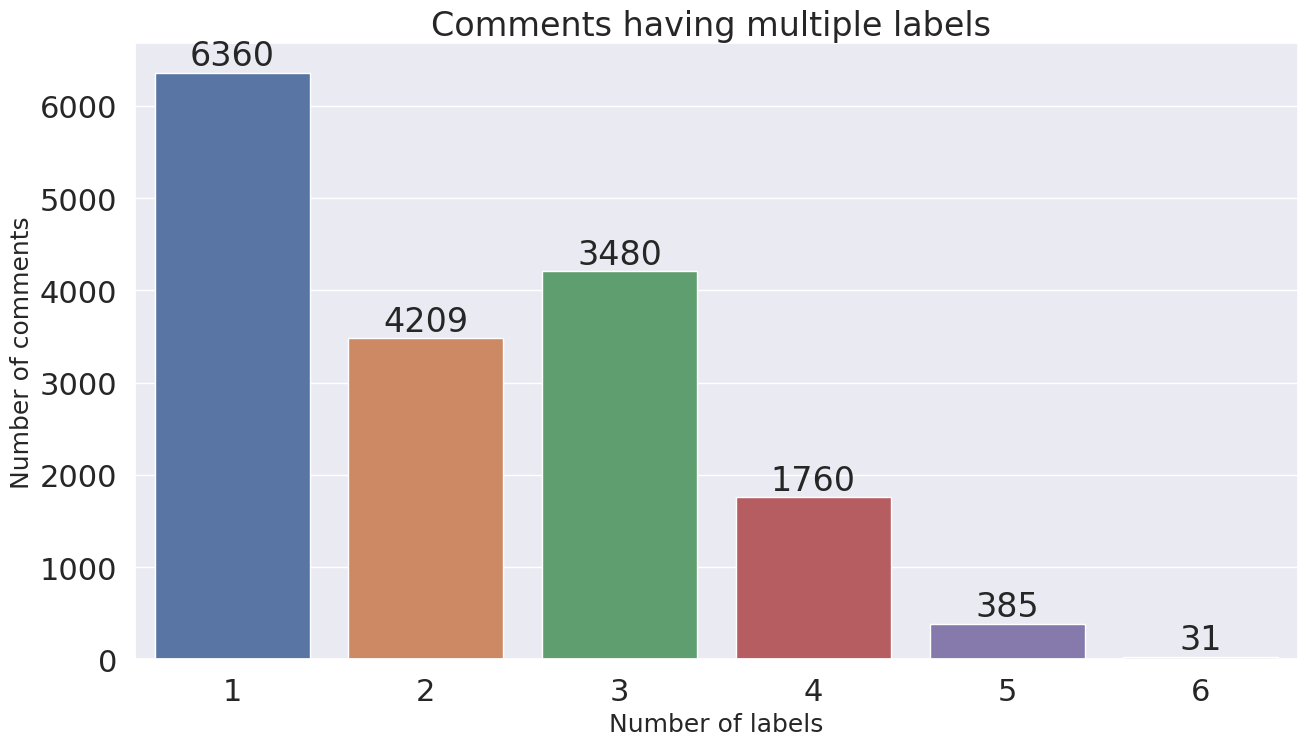

In [ ]:
# COmments having multiple label
rowSums = train_df.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

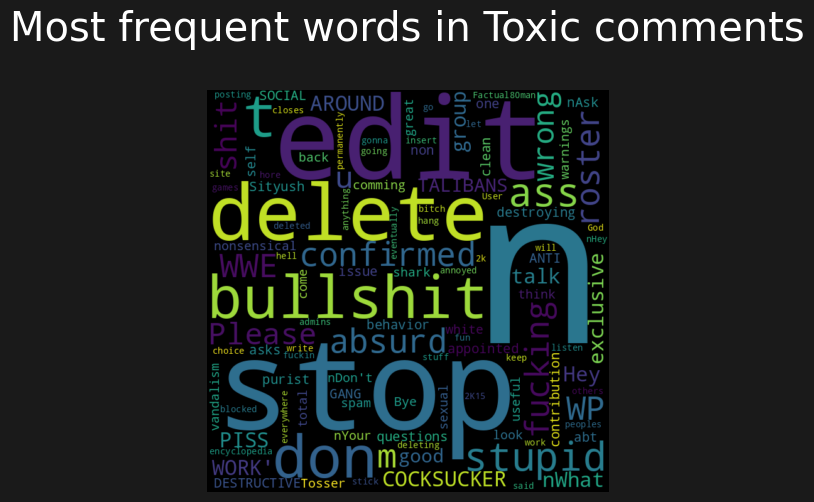

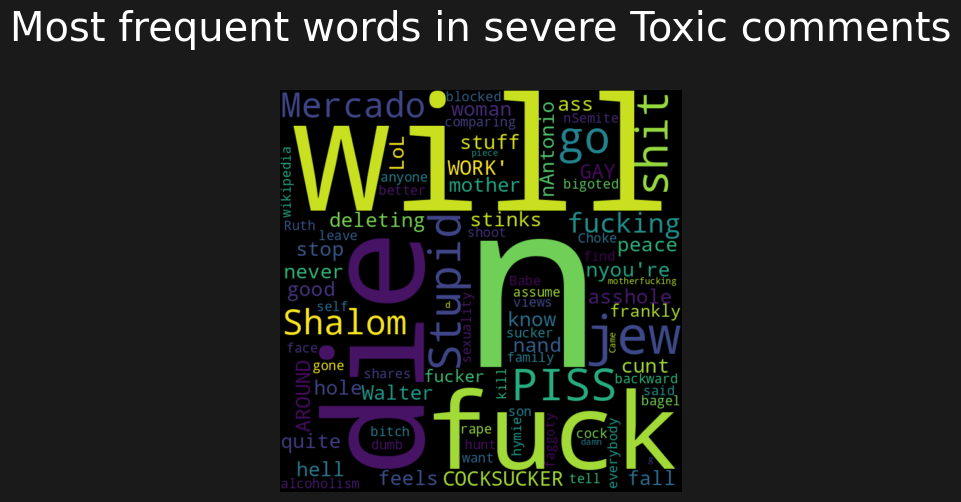

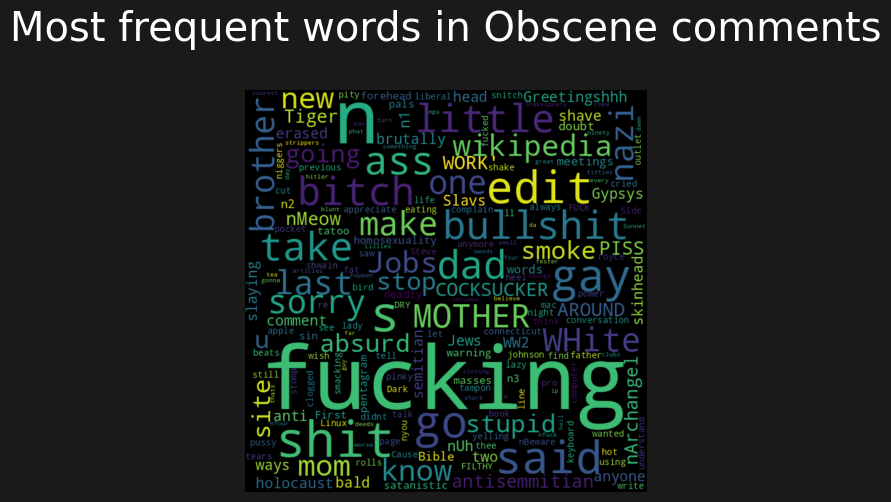

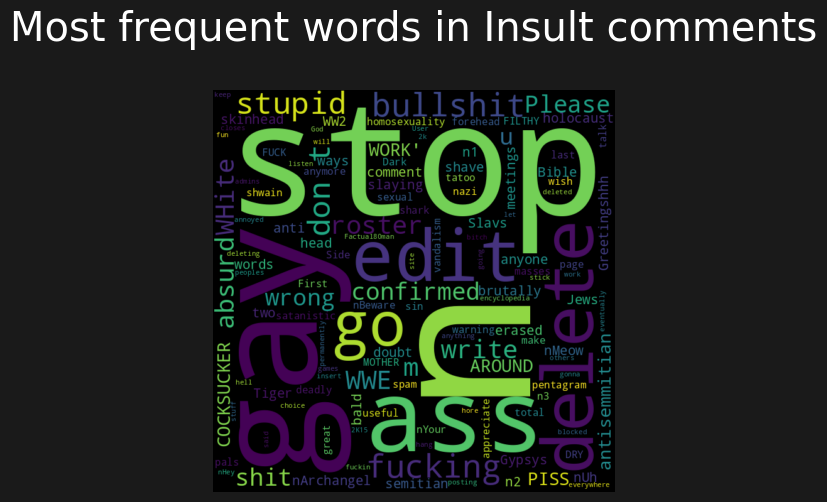

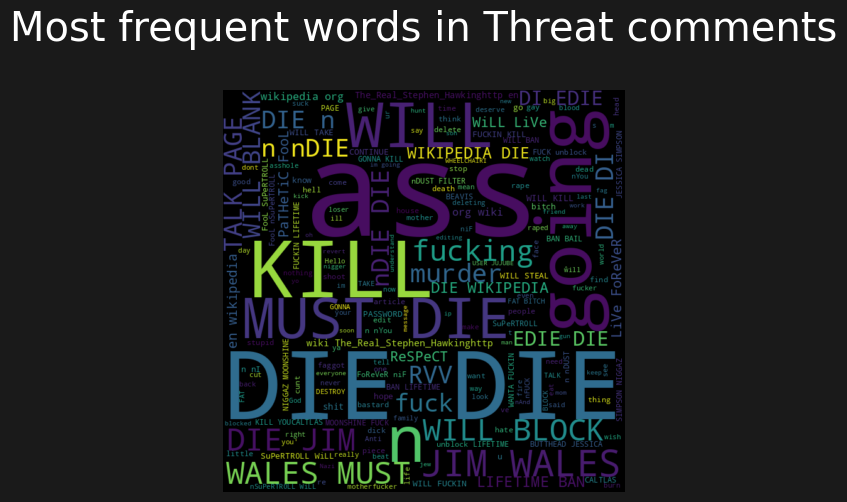

In [ ]:
#Most frequent words in dataset
def word_plot(column,text):

    comments = train_df['comment_text'].loc[column == 1].values     # sort by toxicity

    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the

    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()

word_plot(train_df['toxic'], "Toxic comments")
word_plot(train_df['severe_toxic'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")

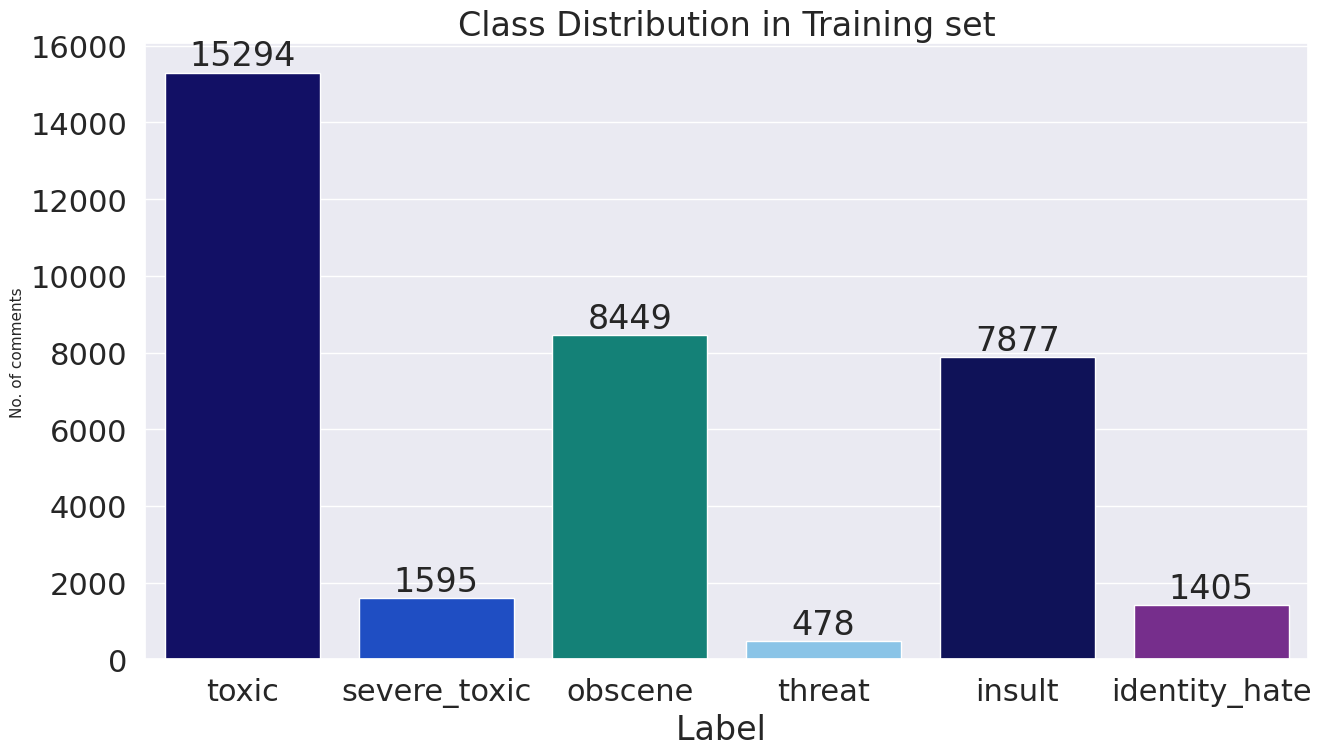

In [ ]:
#Label Distribution
colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = train_df.iloc[:,2:].sum()

plt.figure(figsize=(15,8))

ax= sns.barplot(x=x.index,y=x.values,palette=palette)
plt.title("Class Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

<ipython-input-20-05cdb97b2ad6>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


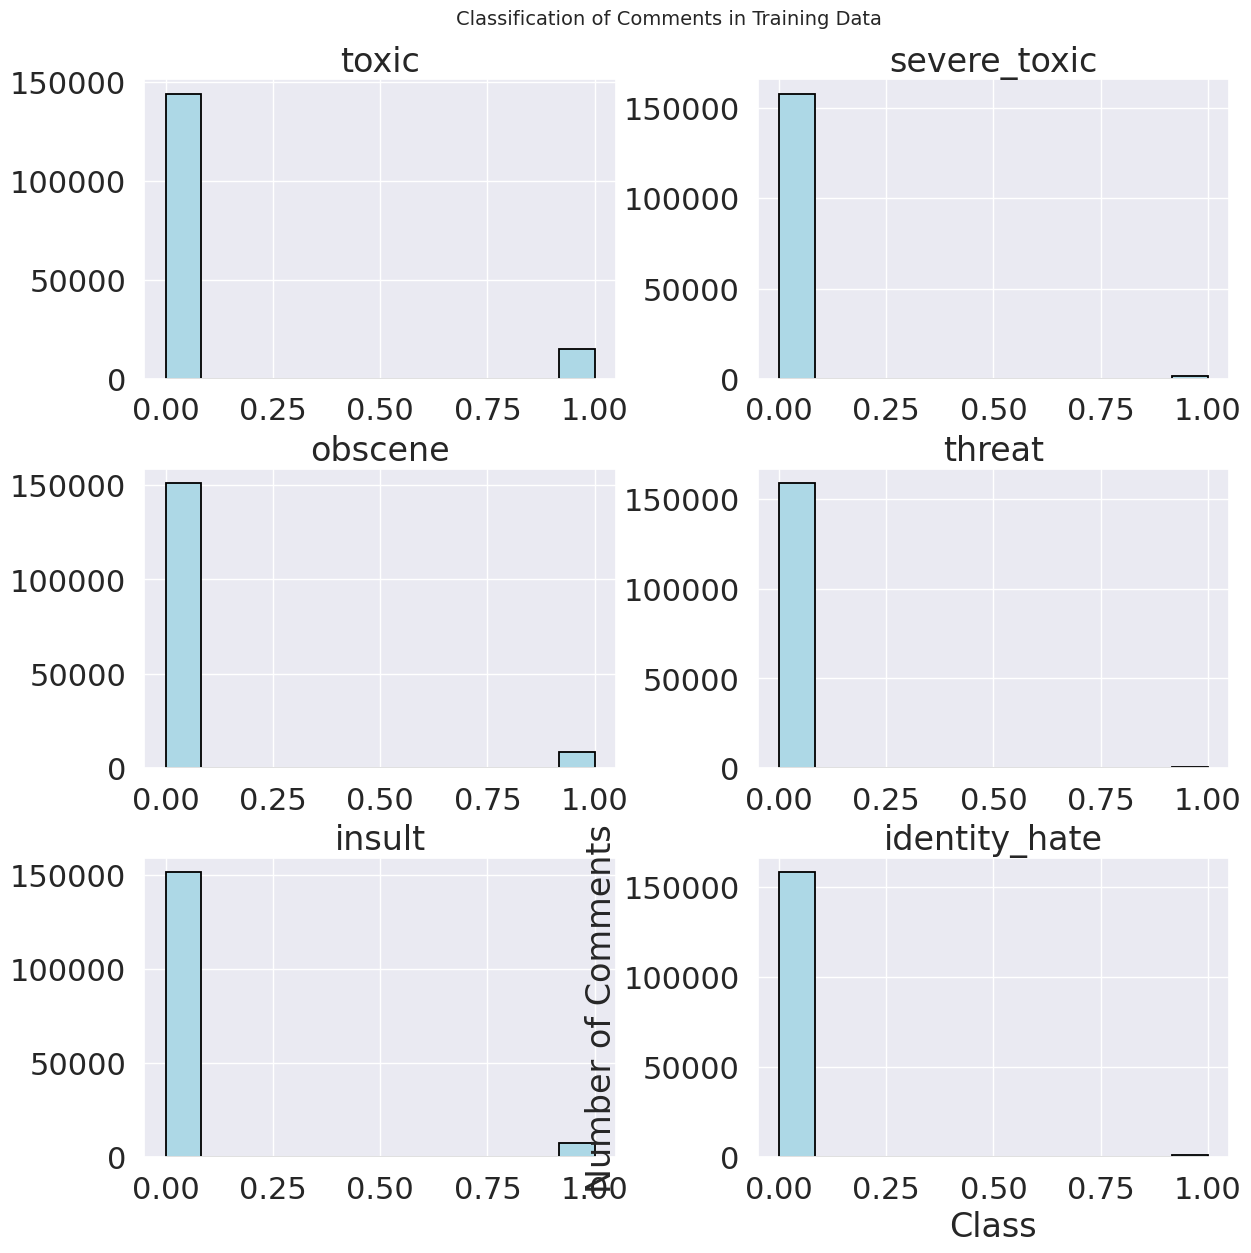

In [ ]:
#Plot Distribution of Training Labels
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

# It can be observed that there is a high imbalance among the classes
# Most of the values are zero for all classes

<ipython-input-21-e987e4d7935b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True,cmap="Blues")


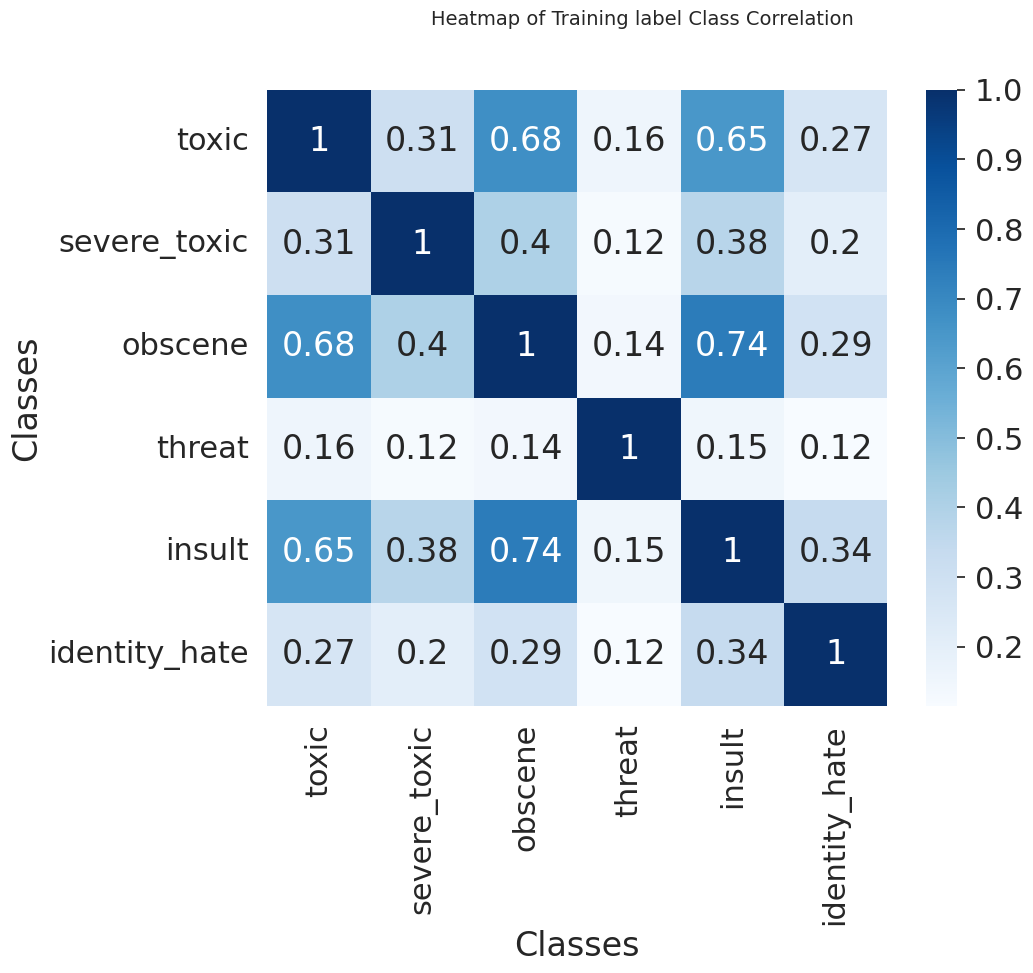

In [ ]:
#Heatmap for training data
fig = plt.figure(figsize = (10,8))
sns.heatmap(train_df.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [ ]:
correlation_val =  train_df.corr()
correlation_val

<ipython-input-22-6fcf339134ae>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_val =  train_df.corr()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [ ]:
abs(correlation_val) >= 0.6

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,True,False,True,False,True,False
severe_toxic,False,True,False,False,False,False
obscene,True,False,True,False,True,False
threat,False,False,False,True,False,False
insult,True,False,True,False,True,False
identity_hate,False,False,False,False,False,True


In [ ]:
# Some classes are highly positively corelated to others Correlation>60%

#-toxic and insult (0.6475)

#toxic and obscene (0.6765)
#obscene and insult (0.7412)
#This means that if a comment is toxic then there is a 67.6% chance it is also obscene and 64.7% chance that it is also classified as insult. Obscene and insult comments are the most correlated with correlation of 74.1%

<Axes: >

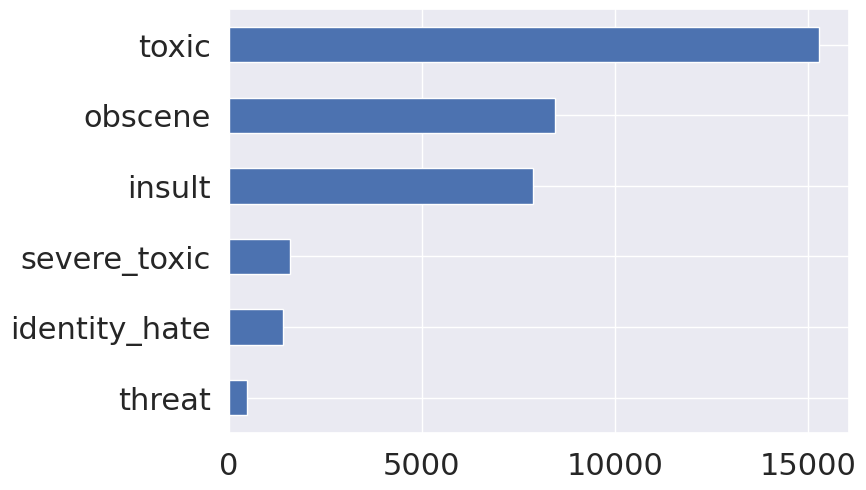

In [ ]:
train_df[categories].sum().sort_values().plot(kind="barh")

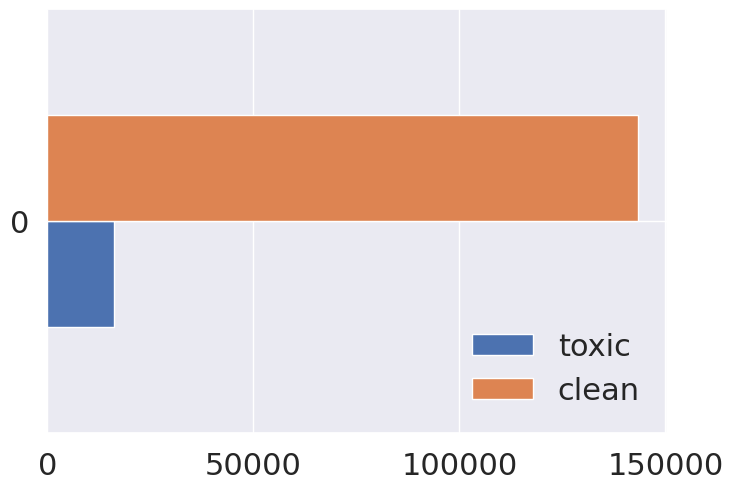

In [ ]:
#Plot of clean vs toxic data
train_toxic_comments = train_df[train_df[categories].sum(axis=1) > 0]
train_clean_comments = train_df[train_df[categories].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic_comments)],
  clean=[len(train_clean_comments)]
)).plot(kind='barh');

In [ ]:
!pip install -q torchmetrics watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.7 MB/s eta 0:00:00


In [ ]:
%load_ext watermark

In [ ]:
%watermark --iversions

torch       : 2.0.0+cu118
numpy       : 1.22.4
pandas      : 1.5.3
re          : 2.2.1
matplotlib  : 3.7.1
transformers: 4.28.1
google      : 2.0.3
seaborn     : 0.12.2
nltk        : 3.8.1
sklearn     : 1.2.2



In [ ]:
samples = train_data.sample(1000)
samples[samples.columns.to_list()[2:]].apply(pd.Series.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,914,993,954,999,962,995
1,86,7,46,1,38,5


In [ ]:
samples["comment_text"] = samples["comment_text"].str.lower()
samples["comment_text"] = samples["comment_text"].str.replace(rf"([{string.punctuation}])+"," ", regex=True)
samples["comment_text"] = samples["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [ ]:
## Zero Shot Classification
task = "zero-shot-classification"
model = "facebook/bart-large-mnli"
#model = distilbert-base-uncased
classifier = pipeline(task, model, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

In [ ]:
samples['scores'] = samples['comment_text'].progress_apply(lambda x: classifier(x, categories, multi_label=True)['scores'])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
result_df = pd.DataFrame(samples['scores'].tolist(), columns=categories)

Category: toxic
Sklearn score: 0.8450078876393058
torchmetrics score: 0.8450078964233398
##############################

Category: severe_toxic
Sklearn score: 0.9115235217954252
torchmetrics score: 0.9115235209465027
##############################

Category: obscene
Sklearn score: 0.8119588004739768
torchmetrics score: 0.8119587898254395
##############################

Category: threat
Sklearn score: 0.955955955955956
torchmetrics score: 0.955955982208252
##############################

Category: insult
Sklearn score: 0.8712933581354634
torchmetrics score: 0.8712933659553528
##############################

Category: identity_hate
Sklearn score: 0.905929648241206
torchmetrics score: 0.905929684638977
##############################



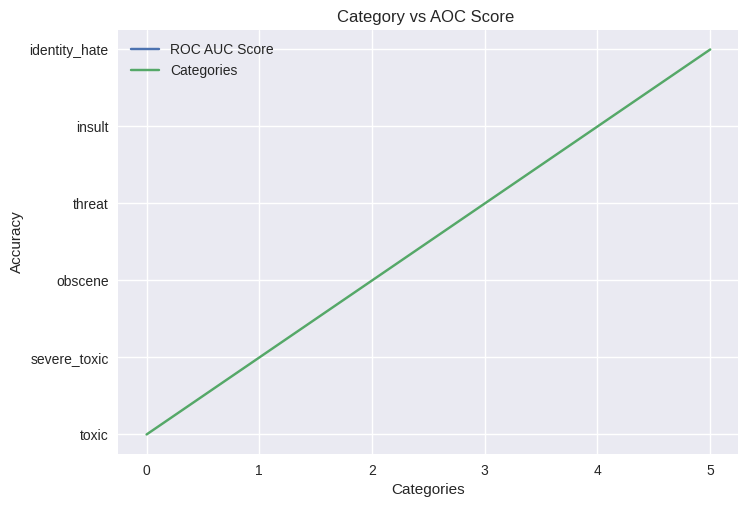

In [ ]:
# Calculating mean column-wise ROC AUC score
for cat in categories:

    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(samples[cat], result_df[cat])}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(result_df[cat].values),torch.tensor(samples[cat].values), thresholds=None)}")
    print("#" * 30)
    print()



# plt.plot(metrics.roc_auc_score(samples[categories], result_df[categories]), label='ROC AUC Score')
# plt.plot(categories, label='Categories')
# plt.title('Category vs AOC Score ')
# plt.xlabel('Categories')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()


In [ ]:
# Mean column-wise ROC AUC score on all categories

print(f"Sklearn score: {metrics.roc_auc_score(samples[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, result_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, average='macro')}")

print(F"torchmetrics score: {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(result_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),torch.tensor(samples[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),num_labels=6,thresholds=None )}")

Sklearn score: 0.883611528706889
torchmetrics score: 0.8836116194725037
